# GPT-5 Video Understanding - Comprehension Video par IA

**Module :** 01-Video-Foundation  
**Niveau :** Debutant  
**Technologies :** OpenAI GPT-5, video understanding, base64 frames  
**Duree estimee :** 40 minutes  
**VRAM :** 0 (API cloud uniquement)  

## Objectifs d'Apprentissage

- [ ] Echantillonner des frames d'une video pour les envoyer a GPT-5
- [ ] Encoder des frames en base64 pour l'API multimodale
- [ ] Obtenir une description de scene et un raisonnement temporel
- [ ] Poser des questions sur le contenu d'une video (Video Q&A)
- [ ] Comparer les strategies d'echantillonnage (uniforme vs keyframe)
- [ ] Analyser du contenu educatif a partir de videos

## Prerequis

- Cle API OpenAI ou OpenRouter configuree (`OPENAI_API_KEY` dans `.env`)
- Notebook 01-1 (Video Operations Basics) complete
- Packages : `openai`, `decord`, `Pillow`, `matplotlib`

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres GPT-5
model_name = "gpt-5-mini"           # "gpt-5", "gpt-5-mini"
n_frames = 8                       # Nombre de frames a envoyer
max_tokens = 1000                  # Tokens de reponse max
temperature = 0.3                  # Basse pour analyse factuelle

# Configuration video
sample_fps = 24                    # FPS de la video de test
sample_duration = 10               # Duree video de test (secondes)
frame_strategy = "uniform"         # "uniform" ou "keyframe"

# Configuration sauvegarde
save_analysis = True               # Sauvegarder les analyses
analyze_video = True               # Executer les analyses (False pour validation seule)

# Chemin vers le fichier .env (peut etre surcharge par Papermill)
env_file_path = ""                 # Chemin absolu vers .env (vide = recherche auto)

In [2]:
# Parameters
notebook_mode = "batch"
skip_widgets = True
env_file_path = (
    "D:\\Dev\\CoursIA.worktrees\\GenAI_Series\\MyIA.AI.Notebooks\\GenAI\\.env"
)


In [3]:
# Setup environnement et imports
import os
import sys
import json
import time
import base64
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from io import BytesIO
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.genai_helpers import setup_genai_logging
        print("Helpers GenAI importes")
    except ImportError:
        print("Helpers GenAI non disponibles - mode autonome")

OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video_gpt5'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('video_gpt5')

print(f"GPT-5 Video Understanding")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}, Modele : {model_name}")
print(f"Frames a envoyer : {n_frames}, Strategie : {frame_strategy}")

Helpers GenAI importes
GPT-5 Video Understanding
Date : 2026-02-25 20:51:07
Mode : batch, Modele : gpt-5-mini
Frames a envoyer : 8, Strategie : uniform


In [4]:
# Chargement .env et configuration API OpenAI
from dotenv import load_dotenv

# Recherche du .env
# Priorite : 1) parametre env_file_path, 2) recherche dans l'arborescence
found_env = False

if env_file_path and Path(env_file_path).exists():
    load_dotenv(env_file_path)
    print(f"Fichier .env charge depuis : {env_file_path}")
    found_env = True
else:
    # Recherche depuis le repertoire courant
    current_path = Path.cwd()
    for _ in range(6):
        env_path = current_path / '.env'
        if env_path.exists():
            load_dotenv(env_path)
            print(f"Fichier .env charge depuis : {env_path}")
            found_env = True
            break
        current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")
    print(f"  Repertoire courant : {Path.cwd()}")

# Configuration client OpenAI
print("\n--- CONFIGURATION API ---")
print("=" * 40)

openai_key = os.getenv('OPENAI_API_KEY')
openai_base = os.getenv('OPENAI_BASE_URL', 'https://api.openai.com/v1')

if not openai_key:
    if notebook_mode == "batch" and not analyze_video:
        print("Mode batch sans analyse : cle API ignoree")
        openai_key = "dummy_key_for_validation"
    else:
        raise ValueError(
            "OPENAI_API_KEY manquante dans .env\n"
            "Configurez votre cle API OpenAI ou OpenRouter."
        )

# Initialisation client
from openai import OpenAI

client = OpenAI(
    api_key=openai_key,
    base_url=openai_base
)

# Test de connexion
if openai_key != "dummy_key_for_validation":
    try:
        models = client.models.list()
        gpt5_models = [m for m in models.data if 'gpt-5' in m.id.lower()]
        print(f"Connexion API reussie")
        if gpt5_models:
            for m in gpt5_models[:3]:
                print(f"  Modele disponible : {m.id}")
        print(f"Modele selectionne : {model_name}")
    except Exception as e:
        print(f"Avertissement connexion : {str(e)[:100]}")
        print("Le notebook continuera, les appels API pourraient echouer.")
else:
    print("Test connexion ignore (dummy key)")

print(f"\nBase URL : {openai_base}")
print(f"Max tokens : {max_tokens}")
print(f"Temperature : {temperature}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- CONFIGURATION API ---


INFO:httpx:HTTP Request: GET https://api.openai.com/v1/models "HTTP/1.1 200 OK"


Connexion API reussie
  Modele disponible : gpt-5.3-codex
  Modele disponible : gpt-5-chat-latest
  Modele disponible : gpt-5-2025-08-07
Modele selectionne : gpt-5-mini

Base URL : https://api.openai.com/v1
Max tokens : 1000
Temperature : 0.3


## Section 1 : Creation de la video de test et extraction de frames

Nous creons une video de test plus riche que dans le notebook 01-1, avec plusieurs
"scenes" distinctes pour que GPT-5 puisse demontrer son raisonnement temporel.
Chaque scene contient des formes, couleurs et textes differents.


--- CREATION VIDEO MULTI-SCENES ---


Video multi-scenes creee
  Fichier : test_multiscene.mp4
  Scenes : 5
  Frames totales : 240
  Duree : 10.0s
  Taille : 54.1 KB


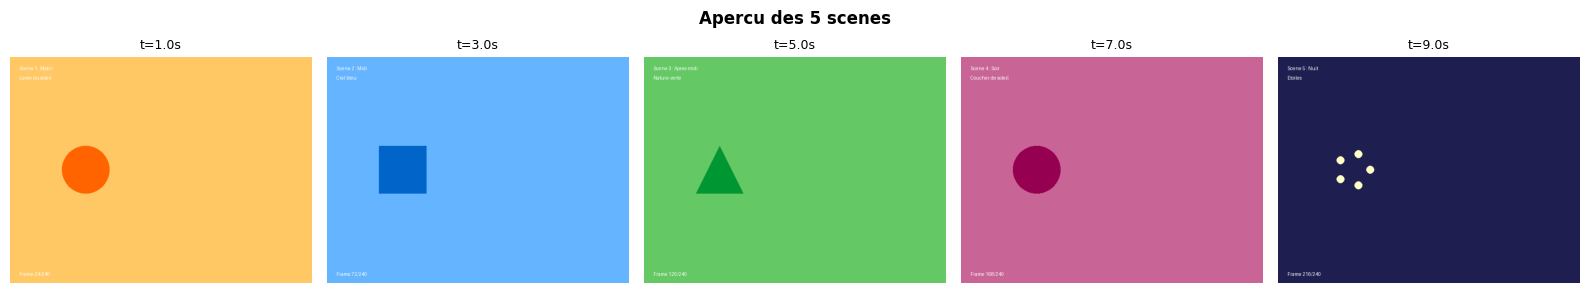

In [5]:
# Creation d'une video multi-scenes pour test
print("\n--- CREATION VIDEO MULTI-SCENES ---")
print("=" * 40)

import imageio

# Definition des scenes
scenes = [
    {"name": "Scene 1 : Matin", "bg_color": (255, 200, 100), "shape": "circle",
     "shape_color": (255, 100, 0), "text": "Lever du soleil"},
    {"name": "Scene 2 : Midi", "bg_color": (100, 180, 255), "shape": "rectangle",
     "shape_color": (0, 100, 200), "text": "Ciel bleu"},
    {"name": "Scene 3 : Apres-midi", "bg_color": (100, 200, 100), "shape": "triangle",
     "shape_color": (0, 150, 50), "text": "Nature verte"},
    {"name": "Scene 4 : Soir", "bg_color": (200, 100, 150), "shape": "circle",
     "shape_color": (150, 0, 80), "text": "Coucher de soleil"},
    {"name": "Scene 5 : Nuit", "bg_color": (30, 30, 80), "shape": "star",
     "shape_color": (255, 255, 200), "text": "Etoiles"},
]

width, height = 640, 480
frames_per_scene = sample_fps * sample_duration // len(scenes)
all_frames = []

for scene_idx, scene in enumerate(scenes):
    for frame_i in range(frames_per_scene):
        t = frame_i / frames_per_scene  # progression dans la scene
        
        img = Image.new('RGB', (width, height), scene['bg_color'])
        draw = ImageDraw.Draw(img)
        
        # Position animee de la forme
        cx = int(width * 0.5 + width * 0.25 * np.cos(2 * np.pi * t))
        cy = int(height * 0.5 + height * 0.2 * np.sin(2 * np.pi * t))
        r = 50
        
        if scene['shape'] == 'circle':
            draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=scene['shape_color'])
        elif scene['shape'] == 'rectangle':
            draw.rectangle([cx-r, cy-r, cx+r, cy+r], fill=scene['shape_color'])
        elif scene['shape'] == 'triangle':
            draw.polygon([(cx, cy-r), (cx-r, cy+r), (cx+r, cy+r)],
                         fill=scene['shape_color'])
        elif scene['shape'] == 'star':
            # Etoile simple a 5 branches (petits cercles)
            for angle in range(0, 360, 72):
                sx = cx + int(r * 0.7 * np.cos(np.radians(angle)))
                sy = cy + int(r * 0.7 * np.sin(np.radians(angle)))
                draw.ellipse([sx-8, sy-8, sx+8, sy+8], fill=scene['shape_color'])
        
        # Texte de la scene
        draw.text((20, 20), scene['name'], fill='white')
        draw.text((20, 40), scene['text'], fill='white')
        global_frame = scene_idx * frames_per_scene + frame_i
        draw.text((20, height - 25), f"Frame {global_frame}/{frames_per_scene * len(scenes)}",
                  fill='white')
        
        all_frames.append(np.array(img))

# Sauvegarder la video
test_video_path = OUTPUT_DIR / "test_multiscene.mp4"
writer = imageio.get_writer(str(test_video_path), fps=sample_fps, codec='libx264')
for frame in all_frames:
    writer.append_data(frame)
writer.close()

total_frames = len(all_frames)
total_duration = total_frames / sample_fps
file_size_kb = test_video_path.stat().st_size / 1024

print(f"Video multi-scenes creee")
print(f"  Fichier : {test_video_path.name}")
print(f"  Scenes : {len(scenes)}")
print(f"  Frames totales : {total_frames}")
print(f"  Duree : {total_duration:.1f}s")
print(f"  Taille : {file_size_kb:.1f} KB")

# Apercu des scenes
scene_preview_indices = [int(i * frames_per_scene + frames_per_scene // 2) for i in range(len(scenes))]
fig, axes = plt.subplots(1, len(scenes), figsize=(16, 3))
for ax, idx in zip(axes, scene_preview_indices):
    ax.imshow(all_frames[idx])
    ax.set_title(f"t={idx/sample_fps:.1f}s", fontsize=9)
    ax.axis('off')
plt.suptitle("Apercu des 5 scenes", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Section 2 : Strategies d'echantillonnage et encodage base64

Pour envoyer une video a GPT-5, on ne transmet pas la video complete mais un echantillon
de N frames encodees en base64. Le choix de la strategie d'echantillonnage impacte
directement la qualite de la comprehension.


--- STRATEGIES D'ECHANTILLONNAGE ---


Echantillonnage uniforme (8 frames) :
  Indices : [0, 34, 68, 102, 136, 170, 204, 239]
  Timestamps : ['0.0s', '1.4s', '2.8s', '4.2s', '5.7s', '7.1s', '8.5s', '10.0s']

Echantillonnage keyframe (8 frames) :
  Indices : [0, 48, 96, 144, 192, 200, 205, 210]
  Timestamps : ['0.0s', '2.0s', '4.0s', '6.0s', '8.0s', '8.3s', '8.5s', '8.8s']


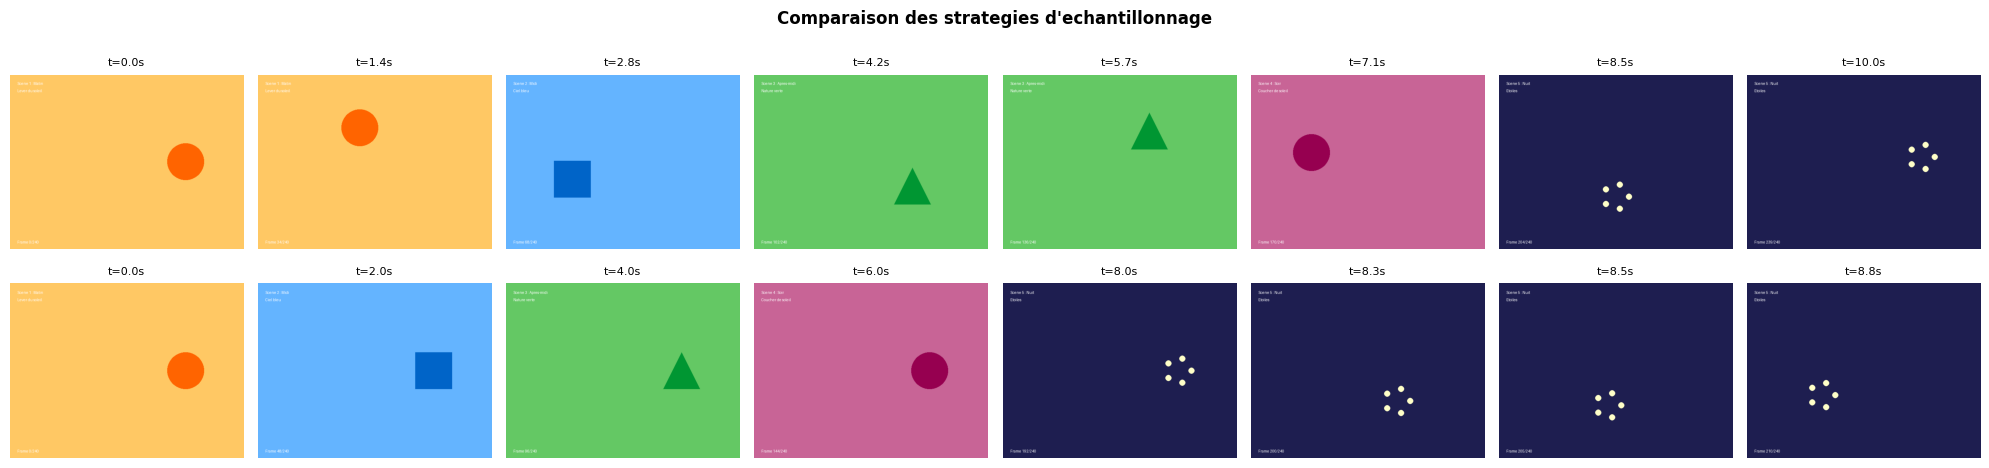


Frames encodees en base64 (strategie : uniform)
  Nombre : 8
  Taille payload totale : 85.5 KB
  Taille moyenne par frame : 10.7 KB


In [6]:
# Strategies d'echantillonnage de frames
print("\n--- STRATEGIES D'ECHANTILLONNAGE ---")
print("=" * 45)

def sample_frames_uniform(frames: List[np.ndarray], n: int) -> Tuple[List[np.ndarray], List[int]]:
    """
    Echantillonnage uniforme : N frames regulierement espacees.
    Avantage : couverture temporelle complete.
    """
    total = len(frames)
    indices = np.linspace(0, total - 1, n, dtype=int).tolist()
    return [frames[i] for i in indices], indices


def sample_frames_keyframe(frames: List[np.ndarray], n: int,
                           threshold: float = 30.0) -> Tuple[List[np.ndarray], List[int]]:
    """
    Echantillonnage par keyframes : detecte les changements de scene.
    Avantage : capture les moments de transition.
    """
    # Calculer la difference entre frames consecutives
    diffs = []
    for i in range(1, len(frames)):
        diff = np.mean(np.abs(frames[i].astype(float) - frames[i-1].astype(float)))
        diffs.append((i, diff))
    
    # Trier par difference decroissante (plus grands changements)
    diffs.sort(key=lambda x: x[1], reverse=True)
    
    # Prendre les N-1 plus grands changements + la premiere frame
    keyframe_indices = [0]
    for idx, diff_val in diffs[:n - 1]:
        keyframe_indices.append(idx)
    
    keyframe_indices.sort()
    return [frames[i] for i in keyframe_indices], keyframe_indices


def encode_frame_base64(frame: np.ndarray, quality: int = 85) -> str:
    """
    Encode une frame numpy en base64 JPEG pour l'API GPT-5.
    """
    img = Image.fromarray(frame)
    buffer = BytesIO()
    img.save(buffer, format='JPEG', quality=quality)
    return base64.b64encode(buffer.getvalue()).decode('utf-8')


# Comparer les deux strategies
uniform_frames, uniform_indices = sample_frames_uniform(all_frames, n_frames)
keyframe_frames, keyframe_indices = sample_frames_keyframe(all_frames, n_frames)

print(f"Echantillonnage uniforme ({n_frames} frames) :")
print(f"  Indices : {uniform_indices}")
print(f"  Timestamps : {[f'{i/sample_fps:.1f}s' for i in uniform_indices]}")

print(f"\nEchantillonnage keyframe ({n_frames} frames) :")
print(f"  Indices : {keyframe_indices}")
print(f"  Timestamps : {[f'{i/sample_fps:.1f}s' for i in keyframe_indices]}")

# Visualisation comparative
fig, axes = plt.subplots(2, n_frames, figsize=(2.5 * n_frames, 5))
for i in range(n_frames):
    axes[0, i].imshow(uniform_frames[i])
    axes[0, i].set_title(f"t={uniform_indices[i]/sample_fps:.1f}s", fontsize=8)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(keyframe_frames[i])
    axes[1, i].set_title(f"t={keyframe_indices[i]/sample_fps:.1f}s", fontsize=8)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Uniforme", fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel("Keyframe", fontsize=10, fontweight='bold')
plt.suptitle("Comparaison des strategies d'echantillonnage", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Encodage base64 des frames selectionnees
strategy = frame_strategy
selected_frames = uniform_frames if strategy == "uniform" else keyframe_frames
selected_indices = uniform_indices if strategy == "uniform" else keyframe_indices

encoded_frames = [encode_frame_base64(f) for f in selected_frames]
total_payload_kb = sum(len(e) for e in encoded_frames) / 1024

print(f"\nFrames encodees en base64 (strategie : {strategy})")
print(f"  Nombre : {len(encoded_frames)}")
print(f"  Taille payload totale : {total_payload_kb:.1f} KB")
print(f"  Taille moyenne par frame : {total_payload_kb / len(encoded_frames):.1f} KB")

### Interpretation : Strategies d'echantillonnage

| Strategie | Avantage | Inconvenient | Cas d'usage |
|-----------|----------|-------------|-------------|
| **Uniforme** | Couverture temporelle reguliere | Peut rater des transitions | Videos a rythme constant |
| **Keyframe** | Capture les changements majeurs | Peut ignorer les passages calmes | Videos avec scenes distinctes |

**Points cles** :
1. Le choix de la strategie depend du type de video et de la question posee
2. Plus de frames = meilleure comprehension mais cout API plus eleve
3. L'encodage JPEG avec quality=85 offre un bon rapport qualite/taille

## Section 3 : Description de scene et raisonnement temporel

Nous envoyons maintenant les frames echantillonnees a GPT-5 pour obtenir
une description de la video et un raisonnement sur la progression temporelle.

In [7]:
# Analyse video avec GPT-5print("\n--- ANALYSE VIDEO AVEC GPT-5 ---")print("=" * 40)def analyze_video_with_gpt5(    encoded_frames: List[str],    frame_timestamps: List[float],    prompt: str,    model: str = "gpt-5-mini",    max_tokens: int = 1000) -> Dict[str, Any]:    """    Envoie des frames video a GPT-5 pour analyse.        Args:        encoded_frames: Liste de frames encodees en base64        frame_timestamps: Timestamps correspondants en secondes        prompt: Question ou instruction d'analyse        model: Modele GPT-5 a utiliser        max_tokens: Nombre max de tokens de reponse        Returns:        Dictionnaire avec analyse, metadonnees et statistiques    """    # Construction du message multimodal    content = []        # Instructions avec contexte temporel    context = (        f"{prompt}\n\n"        f"La video contient {len(encoded_frames)} frames extraites aux timestamps suivants : "        f"{', '.join([f'{t:.1f}s' for t in frame_timestamps])}."    )    content.append({"type": "text", "text": context})        # Ajout des frames    for i, (b64_frame, ts) in enumerate(zip(encoded_frames, frame_timestamps)):        content.append({"type": "text", "text": f"Frame {i+1} (t={ts:.1f}s) :"})        content.append({            "type": "image_url",            "image_url": {                "url": f"data:image/jpeg;base64,{b64_frame}",                "detail": "low"  # Economie de tokens pour les frames video            }        })        start_time = time.time()    try:        # Note: temperature parameter not supported by gpt-5-mini via OpenRouter        response = client.chat.completions.create(            model=model,            messages=[{"role": "user", "content": content}],            max_completion_tokens=max_tokens  # GPT-5 utilise max_completion_tokens        )        elapsed = time.time() - start_time                return {            "success": True,            "analysis": response.choices[0].message.content,            "tokens_used": {                "prompt": response.usage.prompt_tokens,                "completion": response.usage.completion_tokens,                "total": response.usage.total_tokens            },            "response_time": elapsed,            "model": model,            "n_frames": len(encoded_frames)        }    except Exception as e:        return {            "success": False,            "error": str(e),            "response_time": time.time() - start_time        }# Analyse 1 : Description de sceneif analyze_video:    timestamps = [idx / sample_fps for idx in selected_indices]        print("Analyse 1 : Description de scene")    scene_prompt = (        "Decris cette video en francais. Pour chaque frame, identifie la scene, "        "les couleurs dominantes, les formes presentes et le texte visible. "        "Fournis ensuite un resume de la progression temporelle de la video."    )        result_scene = analyze_video_with_gpt5(        encoded_frames, timestamps, scene_prompt,        model=model_name, max_tokens=max_tokens    )        if result_scene['success']:        print(f"  Temps de reponse : {result_scene['response_time']:.2f}s")        print(f"  Tokens utilises : {result_scene['tokens_used']}")        print(f"\n--- Analyse GPT-5 ---")        print(result_scene['analysis'])    else:        print(f"  Erreur : {result_scene['error']}")        # Analyse 2 : Raisonnement temporel    print("\n\nAnalyse 2 : Raisonnement temporel")    temporal_prompt = (        "En analysant la progression des frames dans le temps, reponds en francais :\n"        "1. Combien de scenes distinctes detectes-tu ?\n"        "2. A quels moments les transitions se produisent-elles ?\n"        "3. Y a-t-il un theme ou une narration qui relie les scenes ?\n"        "4. Quels elements changent et quels elements restent constants ?"    )        result_temporal = analyze_video_with_gpt5(        encoded_frames, timestamps, temporal_prompt,        model=model_name, max_tokens=max_tokens    )        if result_temporal['success']:        print(f"  Temps de reponse : {result_temporal['response_time']:.2f}s")        print(f"  Tokens utilises : {result_temporal['tokens_used']}")        print(f"\n--- Raisonnement temporel GPT-5 ---")        print(result_temporal['analysis'])    else:        print(f"  Erreur : {result_temporal['error']}")else:    print("Analyse video desactivee (analyze_video=False)")    result_scene = {"success": False, "error": "Analyse desactivee"}    result_temporal = {"success": False, "error": "Analyse desactivee"}

In [8]:
# Video Q&A : poser des questions sur le contenu
if analyze_video:
    print("\n--- VIDEO Q&A ---")
    print("=" * 40)
    
    questions = [
        "Quelle est la couleur dominante de la premiere scene ?",
        "Combien de formes geometriques differentes apparaissent dans la video ?",
        "La video represente-t-elle un cycle (jour/nuit, saisons, etc.) ?",
    ]
    
    qa_results = []
    for q_idx, question in enumerate(questions, 1):
        print(f"\nQuestion {q_idx} : {question}")
        
        qa_prompt = (
            f"Reponds en francais a cette question sur la video :\n{question}\n\n"
            f"Donne une reponse concise et precise basee sur les frames fournies."
        )
        
        result_qa = analyze_video_with_gpt5(
            encoded_frames, timestamps, qa_prompt,
            model=model_name, max_tokens=300
        )
        
        if result_qa['success']:
            print(f"  Reponse : {result_qa['analysis'][:200]}")
            print(f"  ({result_qa['response_time']:.1f}s, {result_qa['tokens_used']['total']} tokens)")
            qa_results.append({"question": question, "answer": result_qa['analysis'],
                              "tokens": result_qa['tokens_used']['total']})
        else:
            print(f"  Erreur : {result_qa['error']}")
            qa_results.append({"question": question, "error": result_qa['error']})
    
    # Tableau recapitulatif Q&A
    print(f"\nRecapitulatif Q&A :")
    print(f"{'Question':<60} {'Tokens':<10}")
    print("-" * 70)
    for qa in qa_results:
        q_short = qa['question'][:55] + '...' if len(qa['question']) > 55 else qa['question']
        tokens = qa.get('tokens', 'N/A')
        print(f"  {q_short:<60} {tokens:<10}")
else:
    print("Q&A desactive (analyze_video=False)")

Q&A desactive (analyze_video=False)


In [9]:
# Mode interactif - Question personnalisee sur la video
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Posez votre propre question sur la video de test.")
    print("(Laissez vide pour passer a la suite)")
    
    try:
        user_question = input("\nVotre question : ").strip()
        
        if user_question and analyze_video:
            user_prompt = (
                f"Reponds en francais a cette question sur la video :\n{user_question}"
            )
            result_user = analyze_video_with_gpt5(
                encoded_frames, timestamps, user_prompt,
                model=model_name, max_tokens=max_tokens
            )
            if result_user['success']:
                print(f"\nReponse GPT-5 :")
                print(result_user['analysis'])
                print(f"\n({result_user['response_time']:.1f}s, {result_user['tokens_used']['total']} tokens)")
            else:
                print(f"Erreur : {result_user['error']}")
        elif not user_question:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError) as e:
        print(f"\nMode interactif interrompu ({type(e).__name__})")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("\nMode interactif non disponible (execution automatisee)")
        else:
            print(f"\nErreur inattendue : {error_type} - {str(e)[:100]}")
            print("Passage a la suite du notebook")
else:
    print("\nMode batch - Interface interactive desactivee")


Mode batch - Interface interactive desactivee


## Bonnes pratiques et optimisation

| Parametre | Recommandation | Impact |
|-----------|---------------|--------|
| **n_frames** | 4-8 pour videos courtes, 12-16 pour longues | Plus de frames = meilleure comprehension, cout accru |
| **detail** | `low` pour frames video, `high` pour images claires | `low` economise ~65 tokens/image |
| **quality JPEG** | 75-85 | Bon compromis taille/qualite pour l'API |
| **temperature** | 0.1-0.3 pour analyse factuelle | Basse temperature = reponses plus fiables |
| **Strategie** | Uniforme par defaut, keyframe pour scenes variees | Keyframe capture mieux les transitions |

**Estimation des couts** :
- 8 frames en `detail=low` : ~700 tokens d'image
- Prompt + reponse : ~500-1500 tokens de texte
- Total par analyse : ~1200-2200 tokens

**Limitations** :
- GPT-5 ne recoit pas la video, mais des images statiques : pas de perception du mouvement
- Le raisonnement temporel repose sur les indices visuels et textuels dans les frames
- Les videos tres longues necessitent un echantillonnage plus agressif

In [10]:
# Statistiques de session et prochaines etapes
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Modele : {model_name}")
print(f"Strategie : {frame_strategy}")
print(f"Frames envoyees : {n_frames}")
print(f"Payload total : {total_payload_kb:.1f} KB")

# Sauvegarder les resultats
if save_analysis and analyze_video:
    results_file = OUTPUT_DIR / f"gpt5_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    results_data = {
        "model": model_name,
        "n_frames": n_frames,
        "strategy": frame_strategy,
        "scene_analysis": result_scene if result_scene.get('success') else None,
        "temporal_analysis": result_temporal if result_temporal.get('success') else None,
        "timestamp": datetime.now().isoformat()
    }
    # Retirer les champs non serialisables
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(results_data, f, indent=2, ensure_ascii=False, default=str)
    print(f"Resultats sauvegardes : {results_file.name}")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 01-3 : Analyse video locale avec Qwen2.5-VL (GPU, temporal grounding)")
print(f"2. Comparer GPT-5 (API cloud) vs Qwen-VL (local GPU) en qualite et cout")
print(f"3. Notebook 01-4 : Amelioration video avec Real-ESRGAN")
print(f"4. Notebook 01-5 : Generation video avec AnimateDiff")

print(f"\nNotebook 01-2 GPT-5 Video Understanding termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-25 20:51:12
Modele : gpt-5-mini
Strategie : uniform
Frames envoyees : 8
Payload total : 85.5 KB

--- PROCHAINES ETAPES ---
1. Notebook 01-3 : Analyse video locale avec Qwen2.5-VL (GPU, temporal grounding)
2. Comparer GPT-5 (API cloud) vs Qwen-VL (local GPU) en qualite et cout
3. Notebook 01-4 : Amelioration video avec Real-ESRGAN
4. Notebook 01-5 : Generation video avec AnimateDiff

Notebook 01-2 GPT-5 Video Understanding termine - 20:51:12
